In [1]:
import gc
import numpy as np
import matplotlib.pyplot as plt
import torch
from itertools import product
from warnings import filterwarnings

from src.utils.commons import get_config, get_device, set_seed
from src.model.gae import GAE
from torch_geometric.loader import DataLoader
from src.training.train import train
from src.data.loader_paper import GraphDatasetPaper
from src.utils.commons import get_config

filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/paper.yaml')
set_seed(config['config']['seed'])

train_dataset = GraphDatasetPaper(config = config['config'], split = 'train')
val_dataset = GraphDatasetPaper(config = config['config'], split = 'val')
device = get_device()

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=1, 
                          shuffle=False,
                          num_workers=config['training']['num_workers'])

val_loader = DataLoader(dataset=val_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        num_workers=config['training']['num_workers'])

# mu1 = np.array([10e4, 15e4, 20e4, 25e4, 30e4, 35e4, 40e4, 45e4, 50e4, 55e4, 60e4, 65e4, 70e4, 75e4, 80e4, 85e4, 90e4, 95e4, 100e4])
# mu2 = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
# mu_space = [mu1, mu2]
# params = torch.tensor(np.array(list(product(*mu_space))))
# params = params.to(device)

num_graphs = train_dataset.num_graphs
model = GAE(config, num_graphs, device).to(device)

In [2]:
test_tensor = torch.randn(10, 50, 3)

In [3]:
test_tensor[9]

tensor([[ 0.6308,  0.3588,  1.1810],
        [ 0.5529,  0.3724,  0.9069],
        [ 0.8264,  1.6862,  1.2149],
        [-1.1321, -0.1450,  0.7257],
        [-0.0420, -1.3183, -0.9570],
        [ 0.9772, -0.4797, -1.1224],
        [-0.8849, -0.3692,  2.1501],
        [ 0.7844, -1.1235,  0.2079],
        [-0.1963,  0.2764, -0.0770],
        [ 0.5273,  0.8193,  0.1110],
        [-0.2470,  0.4349, -0.6192],
        [ 0.3990,  0.8122,  0.4547],
        [ 1.2557, -0.1341,  0.3766],
        [ 1.2705, -0.2575, -1.5718],
        [-1.5405, -1.3942, -0.8163],
        [-0.5659,  0.4025, -0.6391],
        [ 1.2749,  0.5923,  1.3668],
        [ 1.4212, -0.4964,  0.1558],
        [ 0.1750,  0.9341,  0.8063],
        [-0.9219,  0.4430,  0.2900],
        [-1.1831,  0.7706, -0.3401],
        [ 0.4229,  1.3352,  0.9475],
        [-0.1021, -1.6463,  0.1273],
        [ 0.0141,  0.2674, -1.4675],
        [ 0.9072, -0.6982,  0.6235],
        [-0.1390, -0.8901,  0.9280],
        [ 0.5040,  0.6140,  0.2895],
 

In [4]:
train_dataset[0]

Data(x=[8220, 1], edge_index=[2, 16230], edge_attr=[16230, 2], pos=[8220, 2], edge_weight=[16230], surface_mask=[8220], params=[2])

In [5]:
model

GAE(
  (graph_encoder): GraphEncoder(
    (convolution_layers): ConvolutionLayers(
      (dropout): Dropout(p=0, inplace=False)
      (convs): ModuleList(
        (0-1): 2 x GMMConv(1, 1, dim=2)
      )
    )
  )
  (graph_decoder): GraphDecoder(
    (convolution_layers): ConvolutionLayers(
      (dropout): Dropout(p=0, inplace=False)
      (convs): ModuleList(
        (0-1): 2 x GMMConv(1, 1, dim=2)
      )
    )
  )
  (maptovec): ModuleList(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1-4): 4 x Linear(in_features=100, out_features=100, bias=True)
    (5): Linear(in_features=100, out_features=25, bias=True)
  )
)

In [6]:
model.graph_decoder(test_data, latent_var)

NameError: name 'test_data' is not defined

In [4]:
train_dataset[0].x.shape

torch.Size([8220, 1])

In [6]:
train_dataset[0]

Data(x=[8220, 1], edge_index=[2, 16230], edge_attr=[16230, 2], pos=[8220, 2], edge_weight=[16230], surface_mask=[8220], params=[2])

# Training

In [7]:
history = train(model = model, 
                device = device, 
                train_loader = train_loader, 
                is_val = True,
                val_loader = val_loader, 
                start_up_epoch=50,
                save_best_model=False,
                save_history=False,
                minibatch=False,
                config = config['training'])

train_history, val_history = history

  0%|          | 0/25 [00:00<?, ?it/s]


RuntimeError: expected mat1 and mat2 to have the same dtype, but got: double != float

In [3]:
x = train_dataset[0].x

torch.mean(x, dim = 0)

tensor([0.2001])

## Plot train total loss and val total loss

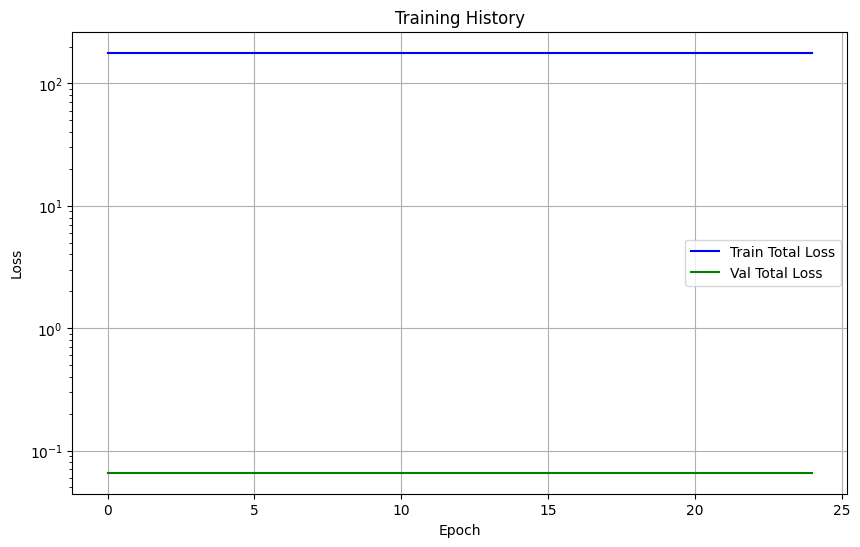

In [10]:
train_total_loss = train_history['train_loss']
val_total_loss = val_history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_total_loss, label='Train Total Loss', color='blue')
plt.plot(val_total_loss, label='Val Total Loss', color='green')
# plt.ylim(0.001, 10)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

## Plot train loss history

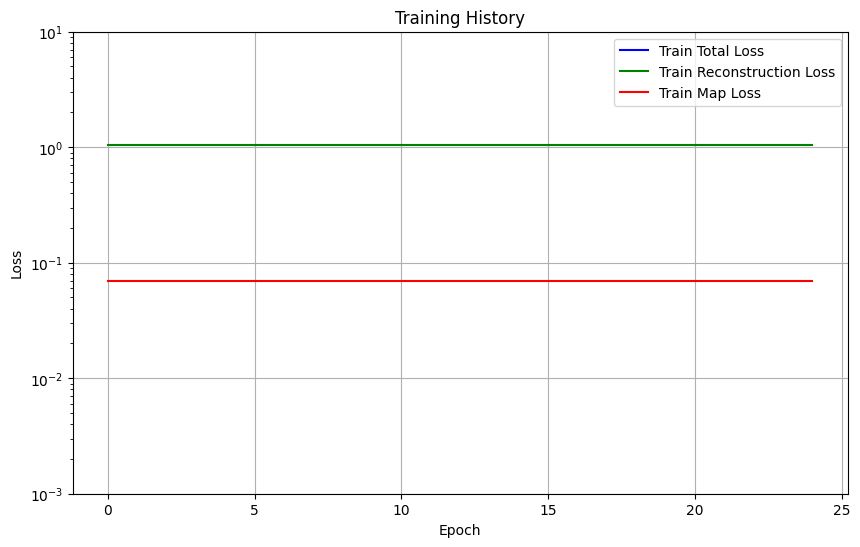

In [11]:
train_total_loss = train_history['train_loss']
train_reconstruction_loss = train_history['reconstruction_loss']
train_map_loss = train_history['map_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_total_loss, label='Train Total Loss', color='blue')
plt.plot(train_reconstruction_loss, label='Train Reconstruction Loss', color='green')
plt.plot(train_map_loss, label='Train Map Loss', color='red')
plt.ylim(0.001, 10)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

## Plot validation loss history

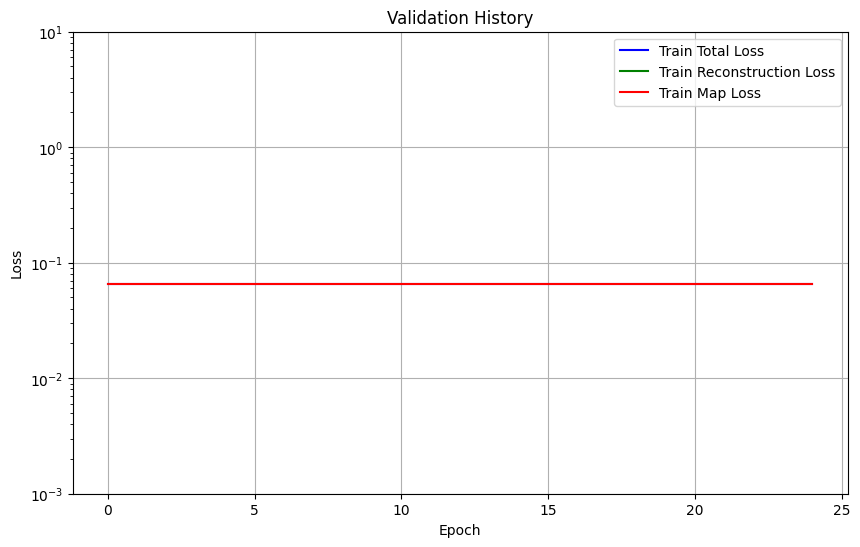

In [12]:
val_total_loss = val_history['val_loss']
val_reconstruction_loss = val_history['reconstruction_loss']
val_map_loss = val_history['map_loss']

plt.figure(figsize=(10, 6))
plt.plot(val_total_loss, label='Train Total Loss', color='blue')
plt.plot(val_reconstruction_loss, label='Train Reconstruction Loss', color='green')
plt.plot(val_map_loss, label='Train Map Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.001, 10)
plt.title('Validation History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

# Plot results

In [13]:
from src.utils.plot import Plot
from src.utils.commons import load_model
import gc
import numpy as np
import torch
from itertools import product
from warnings import filterwarnings

from src.utils.commons import get_config, get_device, set_seed
from src.data.loader_paper import GraphDatasetPaper
from src.utils.commons import get_config

filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/paper.yaml')
set_seed(config['config']['seed'])

train_dataset = GraphDatasetPaper(config = config['config'], split = 'train')
val_dataset = GraphDatasetPaper(config = config['config'], split = 'val')
device = get_device()

# mu1 = np.array([10e4, 15e4, 20e4, 25e4, 30e4, 35e4, 40e4, 45e4, 50e4, 55e4, 60e4, 65e4, 70e4, 75e4, 80e4, 85e4, 90e4, 95e4, 100e4])
# mu2 = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
# mu_space = [mu1, mu2]
# params = torch.tensor(np.array(list(product(*mu_space))))
# params = params.to(device)

# model = load_model("artifacts/GMM_best_model.pth", config=config, num_graphs=val_dataset.num_graphs)
# model = model.to(device)
plot = Plot(train_dataset=train_dataset, val_dataset=val_dataset, model=model)

In [14]:
import matplotlib.pyplot as plt
import os
from torch_geometric.data import Data

def plot_velocity_scatter(data: Data, title: str = "Velocity Field", save=False, xlim=None, ylim=None, colormap='bwr'):
    """Simple scatter plot of velocity field."""
    if data.pos is None or data.x is None:
        print("Error: `data.pos` or `data.x` is None. Cannot plot velocity field.")
        return

    x_coord = data.pos[:, 0].detach().cpu().numpy()
    y_coord = data.pos[:, 1].detach().cpu().numpy()
    vel = data.x.detach().cpu().numpy()
    
    # Ensure vel is 1D for scatter plot
    if vel.ndim > 1:
        vel = vel.flatten()
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    scatter = ax.scatter(x_coord, y_coord, c=vel, cmap=colormap, s=5)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Velocity')
    
    ax.set_aspect('equal', 'box')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    
    plt.tight_layout()

    # if save:
    #     if not os.path.exists(self.save_dir):
    #         os.makedirs(self.save_dir)
    #     plt.savefig(os.path.join(self.save_dir, f"{title}.png"))
    # else:
    plt.show()

    plt.close(fig)

ValueError: z array must have same length as triangulation x and y arrays

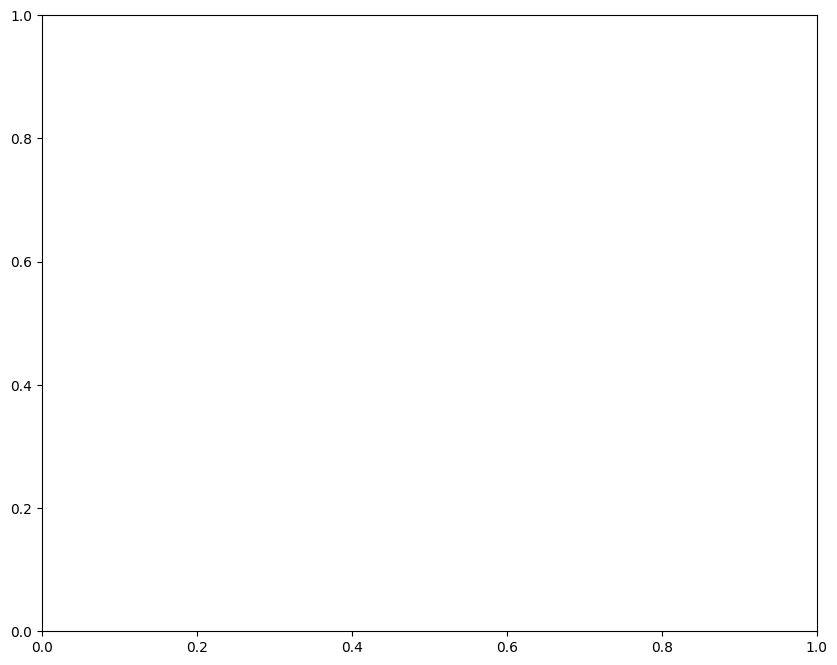

In [15]:
index = 10

test_plot_data = val_dataset[index]
val_trajectories = val_dataset.file_index[index]
test_param = val_dataset[val_trajectories].params.to(device)
test_plot_data = test_plot_data.to(device)

estimated_x, latent_variables, estimated_latent_variables = model(test_plot_data)
predicted = test_plot_data.clone()
predicted.x = estimated_x
estimated_x = estimated_x.detach().cpu().numpy()
params_detached = test_param.detach().cpu().numpy()

plot.plot_velocity_field(data=test_plot_data, title=f"Velocity Field at Re = {test_param[0]} and alpha = {test_param[1]}", save=False, xlim=[-1, 5], ylim=[-1, 2], colormap='bwr')

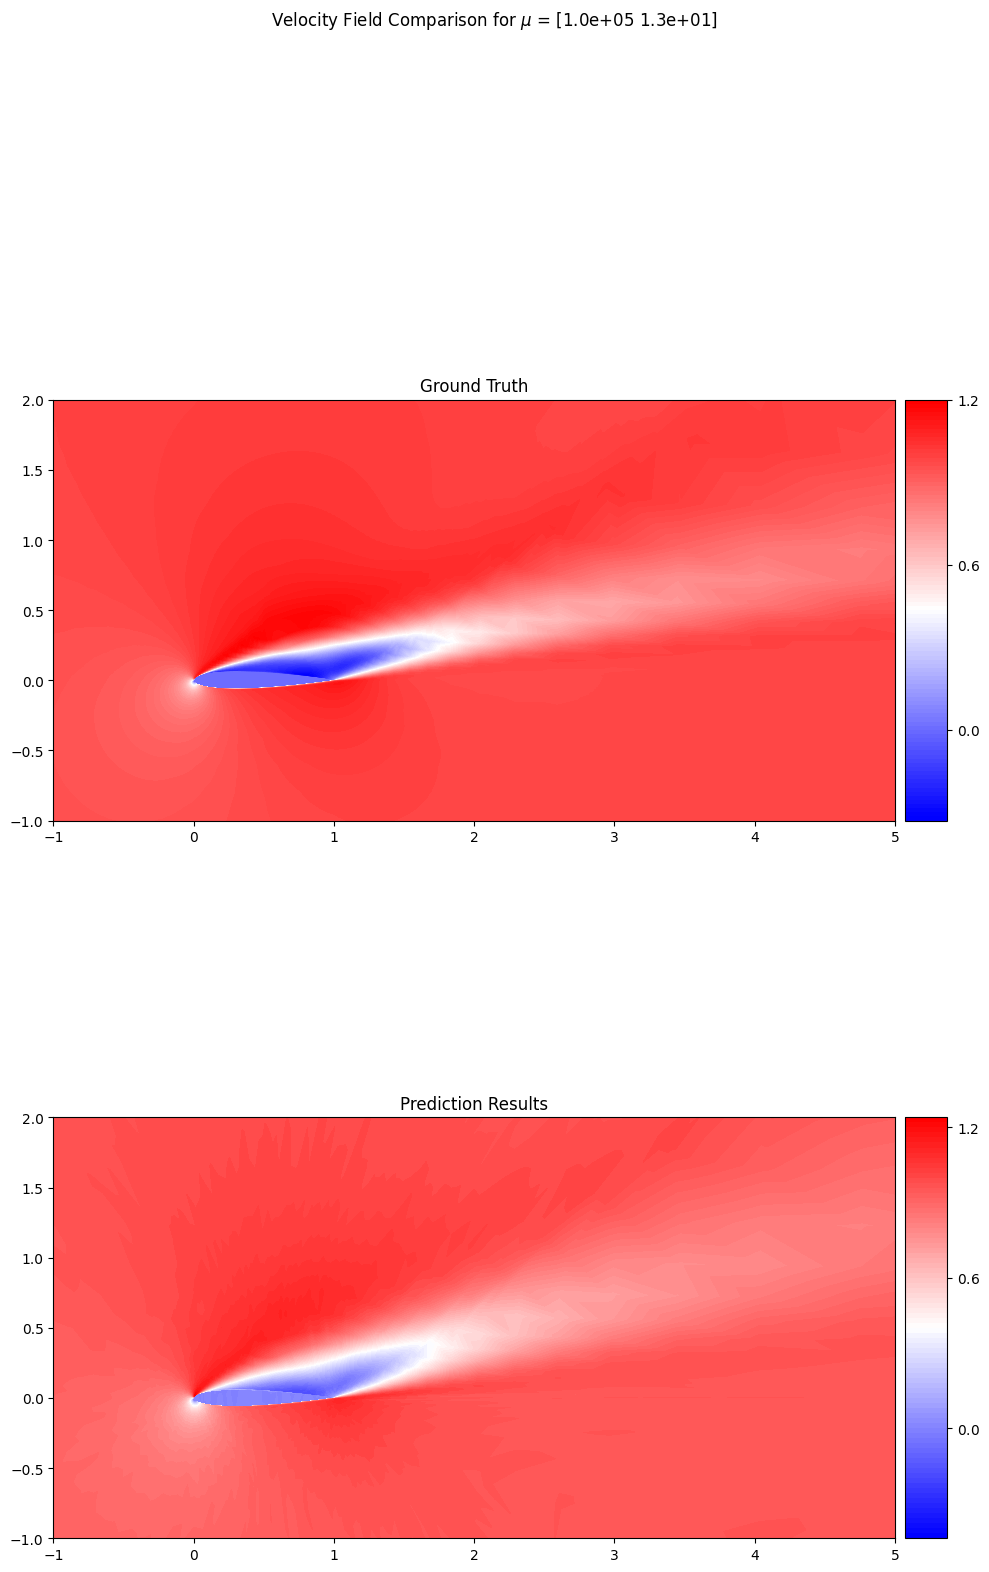

In [3]:
plot.plot_comparison_fields(SNAP = index, device = device, dataset = val_dataset, params = test_param, grid="vertical", colormap='bwr', xlim=[-1, 5], ylim=[-1, 2])

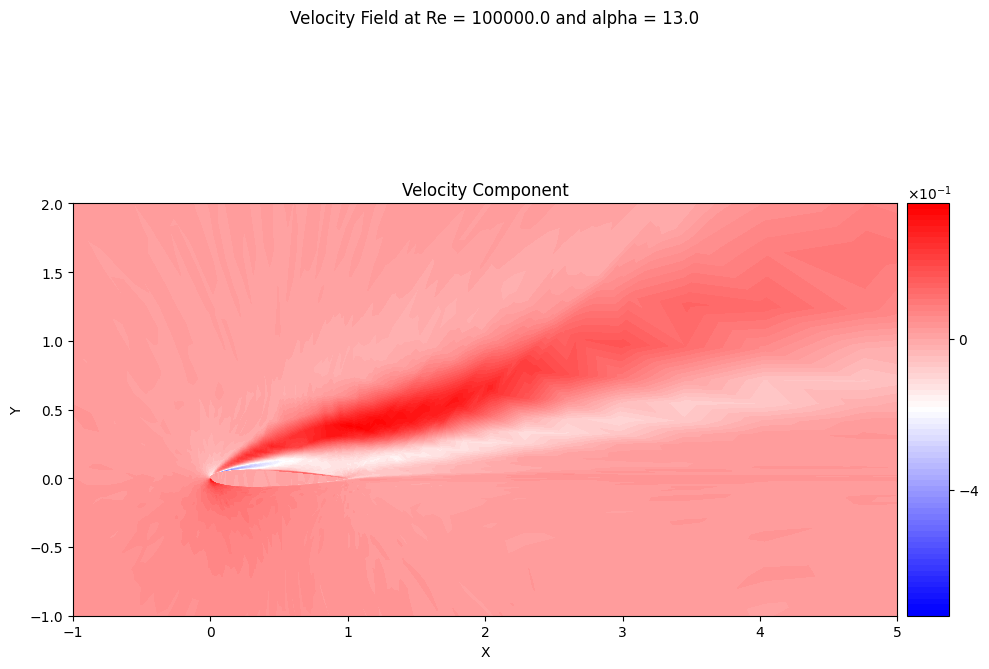

In [4]:
plot.plot_velocity_field_error(data=test_plot_data, params=test_param, device = device, title=f"Velocity Field at Re = {test_param[0]} and alpha = {test_param[1]}", save=False, xlim=[-1, 5], ylim=[-1, 2], colormap='bwr')